# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib 

## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
pip list

## 1.3 Set GPU Growth

In [5]:
# Avoid OOM error by setting GPU Memory Consumption growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [6]:
# Setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [ ]:
# Make directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collecting Anchors, Positives, Negatives

## 2.1 Un-tar Labelled Faces in the Wild Dataset

In [40]:
# http://vis-www.cs.umass.edu/lfw/ 

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the Negative Images Path

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [6]:
# Testing video capture channels
for i in range(10):
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        
        # returning the channels that opened video
        print(f"Device {i}: {cap.getBackendName()}")
        
        cap.release()

Device 0: MSMF
Device 1: DSHOW


In [9]:
# Import uuid library to generate unique image names
import uuid

In [8]:
# Connect to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down frame size to 250x250 pixels
    frame = frame[120:120+250, 200:200+250, :]
    
    # Collecting anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write the frame into the unique file path
        cv2.imwrite(imgname, frame)
        
    # Collecting positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write the frame into the unique file path
        cv2.imwrite(imgname, frame)
        
    # Show image on the screen
    cv2.imshow("Image Collection", frame)
    
    # breaking the loop
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image frame
cv2.destroyAllWindows()

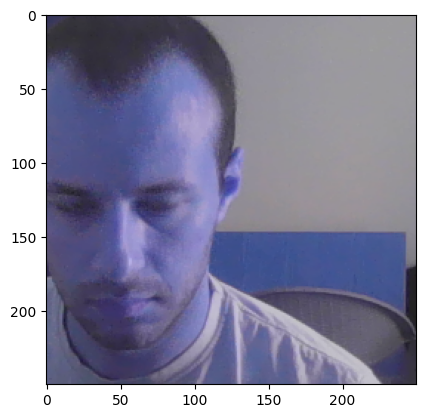

In [9]:
plt.imshow(frame)

## 2.3 Data Augmentation

In [10]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [11]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [12]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [13]:
anchor   = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(5000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(5000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(5000)

In [14]:
# Testing the output of the pipeline
dir_test = anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data\\anchor\\2a6b0773-165e-11ee-856b-f4a475d33f5f.jpg'

## 3.2 Preprocessing - Scale and Resize

In [16]:
def preprocess(file_path):
    
    # Read image from file path
    byte_img = tf.io.read_file(file_path)
    # Load image in jpeg format
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing
    # Resizing image to 100x100x3
    img = tf.image.resize(img, (105,105))
    # Scale image between 0 and 1
    img = img/255.0
    
    return img

## 3.3 Create Labelled Dataset

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
# Testing the labelled dataset
samples = data.as_numpy_iterator()

In [19]:
sample = samples.next()
sample

(b'data\\anchor\\eccf88f2-1679-11ee-aefe-f4a475d33f5f.jpg',
 b'data\\positive\\c83cc38d-1679-11ee-9da5-f4a475d33f5f.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [21]:
# Testing the preprocessed labelled dataset
preprocess_twin(*sample)

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.6513561 , 0.6748855 , 0.6356698 ],
         [0.65236765, 0.67589706, 0.6366814 ],
         [0.6509804 , 0.6745098 , 0.63529414],
         ...,
         [0.65489084, 0.65489084, 0.6470477 ],
         [0.65863013, 0.65863013, 0.650787  ],
         [0.6563959 , 0.6563959 , 0.6485528 ]],
 
        [[0.64685875, 0.6695478 , 0.6311725 ],
         [0.65520203, 0.67789114, 0.63951576],
         [0.6518207 , 0.6745098 , 0.63613445],
         ...,
         [0.65353477, 0.65353477, 0.64569163],
         [0.6582833 , 0.6582833 , 0.65044016],
         [0.6572429 , 0.6572429 , 0.64939976]],
 
        [[0.66163576, 0.67340046, 0.6459495 ],
         [0.6627451 , 0.6745098 , 0.64705884],
         [0.6631186 , 0.6748833 , 0.6474323 ],
         ...,
         [0.66059756, 0.66059756, 0.6527544 ],
         [0.6512605 , 0.6512605 , 0.64341736],
         [0.6515406 , 0.6515406 , 0.64369744]],
 
        ...,
 
        [[0.29589167, 0.3154995 

In [22]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = train_data.batch(16)
test_data = train_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [25]:
def make_embedding():
    # input layer
    inp = Input(shape=(105,105,3), name='input_image')
    
    # first block
    c1  = Conv2D(64, (10,10), activation='relu')(inp)
    m1  = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # second block                   
    c2  = Conv2D(128, (7,7), activation='relu')(m1)
    m2  = MaxPooling2D(64, (2,2), padding='same')(c2)
 
    # third block                   
    c3  = Conv2D(128, (4,4), activation='relu')(m2)
    m3  = MaxPooling2D(64, (2,2), padding='same')(c3)
                       
    # fourth block
    c4  = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
                        
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [26]:
embedding = make_embedding()

In [27]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## 4.2 Build Distance Layer

In [28]:
# Creating a custom layer class for Siamese L1 Distance
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
     
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Make Siamese Model

In [29]:
def make_siamese_model():
    
    # Handle anchor image
    input_image = Input(name='input_image', shape=(105,105,3))
    
    # Handle validation image
    validation_image = Input(name='validation_image', shape=(105,105,3))
    
    # Combine siamese distance compnents
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siamese_network')

In [30]:
siamese_model = make_siamese_model()

In [31]:
siamese_model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[

# 5. Training

## 5.1  Setup Loss Function and Optimizer

In [32]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [33]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [35]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative images
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # forward prob
        yhat = siamese_model(X, training=True)
        #calculate loss
        loss = binary_cross_loss(y, yhat)
        
    #calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #backward prob
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

## 5.4 Build Training Loop

In [36]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train_step 
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the Model

In [37]:
EPOCHS = 50

In [38]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [40]:
train(train_data, EPOCHS)

# 6. Evaluate Model

## 6.1 Import Metrics

In [37]:
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [38]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [39]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[9.9999952e-01],
       [9.9999988e-01],
       [9.9999523e-01],
       [9.9999988e-01],
       [1.7744978e-10],
       [1.0000000e+00],
       [7.4086945e-09],
       [3.8493646e-11],
       [7.5743939e-10],
       [9.9999249e-01],
       [8.2994651e-09],
       [1.0000000e+00],
       [1.4046976e-09],
       [9.9999261e-01],
       [1.0000000e+00],
       [9.9999225e-01]], dtype=float32)

In [40]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]

In [41]:
y_true

array([1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [42]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [43]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

## 6.4 Visualize Results

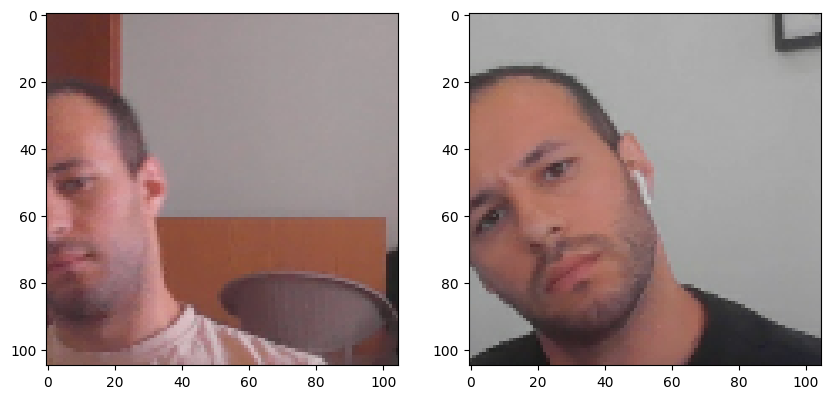

In [44]:
# Set plot size
plt.figure(figsize=(10,8))

example = 1

# Plotting in the first position of the plot grid
plt.subplot(1,2,1)
plt.imshow(test_input[example])

# Plotting in the second position of the plot grid
plt.subplot(1,2,2)
plt.imshow(test_val[example])

# Rendering
plt.show()

# 7. Save Model

In [45]:
# Save model
siamese_model.save('siamesemodel.h5')

In [46]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                  custom_objects={'L1Dist':L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

# 8. Real Time Test

## 8.1 Verification Function

In [47]:
def verify(model, detection_threshold, verification_threshold):
    # Build resulst array
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_image = preprocess(os.path.join('application_data','verification_images',image))
        
        # The model expects input data in a batch format, even for a single image.
        # np.expand_dims() adds an extra dimension to the input data, creating a batch with a single image.
        # list() converts the resulting array into a Python list, which can be passed to the model's predict() function.
        result = model.predict(list(np.expand_dims([input_img, validation_image], axis = 1)))
        results.append(result)
     
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified
    
    

## 8.2 OpenCV Real Time Verification

In [48]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to input_image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap. release()
cv2.destroyAllWindows()

True
True
False
True
True
False
False
False
